# Plot to rerun different policies on historical data

In [113]:
##############################################################################################################
### make_synthetic_data_plots.py - python script to create synthetic data and related plots
### Project started May 2017, last update Jan 2020
##############################################################################################################

import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sbn
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import importlib
from datetime import datetime
import sys
sys.path.insert(1, 'code/synthetic_data_and_moea_plots/')
import warnings
warnings.filterwarnings('ignore')

### Project functions ###
import functions_clean_data
import functions_synthetic_data
import functions_revenues_contracts
import functions_moea_output_plots


sbn.set_style('white')
sbn.set_context('paper', font_scale=1.55)

eps = 1e-13
startTime = datetime.now()

dir_downloaded_inputs = './data/downloaded_inputs/'
dir_generated_inputs = './data/generated_inputs/'
dir_moea_output = './data/optimization_output/'
dir_figs = './figures/'



### Get and clean data
# SWE
importlib.reload(functions_clean_data)
swe = functions_clean_data.get_clean_swe(dir_downloaded_inputs)

# hydro generation (GWh/mnth)
gen = functions_clean_data.get_historical_generation(dir_downloaded_inputs, swe).reset_index()

# wholesale power price ($/MWh), inflation adjusted
power = functions_clean_data.get_historical_power(dir_downloaded_inputs)

# SFPUC fin year sales and rates
hp_GWh, hp_dolPerKwh, hp_dolM = functions_clean_data.get_historical_SFPUC_sales()




### Generate synthetic time series
# # SWE, Feb 1 & Apr 1
print('Generating synthetic swe..., ', datetime.now() - startTime)
importlib.reload(functions_synthetic_data)
sweSynth = functions_synthetic_data.synthetic_swe(dir_generated_inputs, swe, redo = False, save = False)

# monthly generation, dependent on swe. Will also create fig S2, showing fitted models (gen as fn of swe) for each month.
print('Generating synthetic hydropower generation..., ', datetime.now() - startTime)
genSynth = functions_synthetic_data.synthetic_generation(dir_generated_inputs, dir_figs, gen, sweSynth, redo = False, save = False, plot = False)


# monthly power price
print('Generating synthetic power prices..., ', datetime.now() - startTime)
importlib.reload(functions_synthetic_data)
powSynth = functions_synthetic_data.synthetic_power(dir_generated_inputs, power, redo = False, save = False)

### Simulate revenues and hedge payouts
# monthly revenues for SFPUC model
print('Generating simulated revenues..., ', datetime.now() - startTime)
importlib.reload(functions_revenues_contracts)
revHist, powHistSample, revSim = functions_revenues_contracts.simulate_revenue(dir_generated_inputs, gen, hp_GWh,
                                                                               hp_dolPerKwh, genSynth, powSynth,
                                                                               redo = False, save = False)

# get index from swe/revenue relationship.
nYr = int(len(revSim) / 12)
yrSim = np.full((1, nYr * 12), 0)
for i in range(1, nYr):
  yrSim[0, (12 * i):(12 * (i + 1))] = i
revSimWyr = revSim.groupby(yrSim[0, :(nYr * 12)]).sum()
revHistWyr = revHist.groupby('wyear').sum()
genSynthWyr = genSynth.groupby(yrSim[0, :(nYr * 12)]).sum()
genHistWyr = gen.groupby(yrSim[0, :len(powHistSample)]).sum()
powSynthWyr = powSynth.groupby(yrSim[0, :(nYr * 12)]).mean()
powHistWyr = powHistSample.groupby(yrSim[0, :len(powHistSample)]).mean()
print(powHistSample)
print(powHistWyr)
lmRevSWE = sm.ols(formula='rev ~ sweFeb + sweApr', data=pd.DataFrame(
  {'rev': revSimWyr.values, 'sweFeb': sweSynth.danFeb.values,
   'sweApr': sweSynth.danApr.values}))
lmRevSWE = lmRevSWE.fit()
# print(lmRevSWE.summary())

sweWtParams = [lmRevSWE.params[1]/(lmRevSWE.params[1]+lmRevSWE.params[2]), lmRevSWE.params[2]/(lmRevSWE.params[1]+lmRevSWE.params[2])]
sweWtSynth = (sweWtParams[0] * sweSynth.danFeb + sweWtParams[1] * sweSynth.danApr)

genSynth['sweWt'] = (sweWtParams[0] * genSynth.sweFeb + sweWtParams[1] * genSynth.sweApr)
gen['sweWt'] = (sweWtParams[0] * gen.sweFeb + sweWtParams[1] * gen.sweApr)


### fixed cost parameters
meanRevenue = np.mean(revSimWyr)
fixedCostFraction =  0.914
# payout for swe-based capped contract for differences (cfd), centered around 50th percentile
print('Generating simulated CFD net payouts..., ', datetime.now() - startTime)
payoutCfdSim = functions_revenues_contracts.snow_contract_payout(dir_generated_inputs, sweWtSynth, contractType = 'cfd',
                                                               lambdaRisk = 0.25, strikeQuantile = 0.5,
                                                               capQuantile = 0.95, redo = False, save = False)

Generating synthetic swe...,  0:00:00.437313
Generating synthetic hydropower generation...,  0:00:00.449068
Generating synthetic power prices...,  0:00:01.899824
Generating simulated revenues...,  0:00:02.699726
0      33.014058
1      30.774794
2      26.057271
3      24.642585
4      31.246040
         ...    
343    48.762747
344    49.924929
345    50.116104
346    48.163653
347    51.178562
Name: powPrice, Length: 348, dtype: float64
0     37.483486
1     46.623459
2     37.981812
3     29.341614
4     46.140473
5     44.621726
6     44.738591
7     50.626491
8     32.165629
9     36.997428
10    45.506152
11    48.428141
12    37.764791
13    45.660620
14    35.808839
15    41.849682
16    31.093984
17    40.381197
18    46.765539
19    34.012431
20    27.693661
21    37.812598
22    51.228436
23    39.116160
24    42.563617
25    38.226268
26    45.803822
27    32.431265
28    45.154503
Name: powPrice, dtype: float64
Generating simulated CFD net payouts...,  0:00:06.178565


In [114]:
# ### get stochastic data
synthetic_data = pd.read_csv(dir_generated_inputs + 'synthetic_data.txt', sep=' ')
print(synthetic_data)


# ### constants
meanRevenue = np.mean(synthetic_data.revenue)
minSnowContract = 0.05
minMaxFund = 0.05
nYears=20
p_sfpuc = 150

### read in moea solutions for each LHC param sample
importlib.reload(functions_moea_output_plots)
moea_solns_filtered = functions_moea_output_plots.get_moea_output(dir_generated_inputs, dir_moea_output, p_sfpuc,
                                                                  meanRevenue, minSnowContract, minMaxFund,
                                                                  debt_filter=True)
moea_solns_unfiltered = functions_moea_output_plots.get_moea_output(dir_generated_inputs, dir_moea_output, p_sfpuc,
                                                                    meanRevenue, minSnowContract, minMaxFund,
                                                                    debt_filter=False)

### choose 3 example policies for plotting from sfpuc baseline params
cases_sfpuc_index = [1585,1595,1597]
params_sfpuc = moea_solns_filtered.loc[moea_solns_filtered.p==p_sfpuc].iloc[0,:].loc[['Delta_debt','Delta_fund','c','delta','lam_prem_shift','expected_net_revenue']]

              swe     revenue  payoutCfd
0       28.981218  127.559145  -4.261692
1       13.604639  118.150442  11.114886
2        8.967480  107.367828  15.752045
3       20.565263  111.545275   4.154263
4        9.674906  102.074198  15.044620
...           ...         ...        ...
999994   7.565927  110.661074  17.153598
999995  31.131994  141.535864  -6.412469
999996  25.865000  122.406355  -1.145474
999997  16.671444  120.313401   8.048081
999998  28.405669  141.723221  -3.686144

[999999 rows x 3 columns]


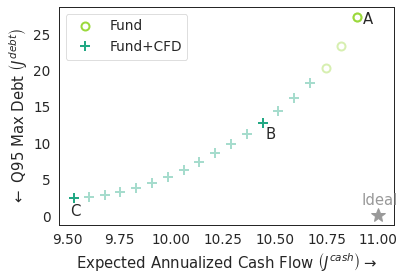

In [115]:
### plot Pareto front for sfpuc baseline parameters (fig 8)
# index of 3 cases to highlight in plot [A = high cash flow, B = compromise, C = low debt]
functions_moea_output_plots.plot_pareto_baseline(dir_figs, moea_solns_filtered, p_sfpuc, cases_sfpuc_index)

In [116]:
### get historical swe, gen, power price, revenue, net revenue. Period of record for hydropower = WY 1988-2016
dat = pd.DataFrame({'swe': swe.loc[revHistWyr.index,:].avg})
dat['gen'] = genHistWyr.tot.values/1000
powHistWyr.index = revHistWyr.index
dat['pow'] = powHistWyr
dat['rev'] = revHistWyr.rev
dat['netrev'] = dat['rev'] - (meanRevenue * params_sfpuc['c'])
print(dat['pow'])

wyear
1988    37.483486
1989    46.623459
1990    37.981812
1991    29.341614
1992    46.140473
1993    44.621726
1994    44.738591
1995    50.626491
1996    32.165629
1997    36.997428
1998    45.506152
1999    48.428141
2000    37.764791
2001    45.660620
2002    35.808839
2003    41.849682
2004    31.093984
2005    40.381197
2006    46.765539
2007    34.012431
2008    27.693661
2009    37.812598
2010    51.228436
2011    39.116160
2012    42.563617
2013    38.226268
2014    45.803822
2015    32.431265
2016    45.154503
Name: pow, dtype: float64


In [117]:
# get unit swe payout for historic data
kinkY = np.min(payoutCfdSim)
kinkX = np.min(sweWtSynth.loc[payoutCfdSim < kinkY + eps])
def payout(swe_value, kinkX, kinkY):
    if (swe_value >= kinkX):
        return kinkY 
    else:
        return kinkY + (kinkX - swe_value)
dat['cfd'] = [payout(x, kinkX, kinkY) for x in dat['swe']]

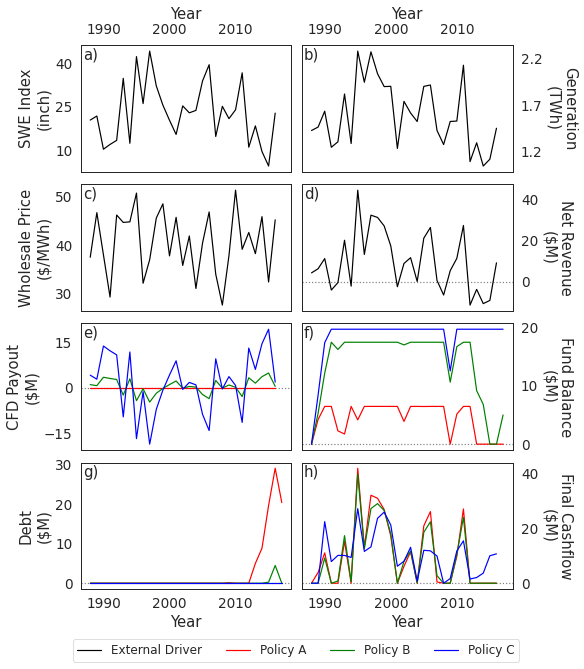

In [152]:
solns = moea_solns_filtered.iloc[cases_sfpuc_index,:]
fixedCostFraction = params_sfpuc['c']
discountRate = 1 / (params_sfpuc['delta'] / 100 + 1)
interestFund = (params_sfpuc['Delta_fund'] + params_sfpuc['delta']) / 100 + 1
interestDebt = (params_sfpuc['Delta_debt'] + params_sfpuc['delta']) / 100 + 1
lambdaCfdPremiumShift = params_sfpuc['lam_prem_shift']
nYears = dat.shape[0]
discFactor = discountRate ** np.array(range(1,nYears+1))
discNorm = 1 / np.sum(discFactor)

cols = ['r','g','b']

fig = plt.figure(figsize=(6,10))
gs1 = fig.add_gridspec(nrows=4, ncols=2, left=0, right=1, wspace=0.05, hspace=0.1)

ax = fig.add_subplot(gs1[0,0])
ax.annotate('a)', xy=(0.01, 0.89), xycoords='axes fraction')
ax.set_ylabel('SWE Index\n(inch)')
ax.set_xlabel('Year')
ax.set_yticks([10,25,40])
# ax.set_xticks(np.arange(0.85, 0.98, 0.04))
ax.tick_params(axis='y',which='both',labelleft=True,labelright=False)
ax.tick_params(axis='x',which='both',labelbottom=False,labeltop=True)
ax.xaxis.set_label_position('top')
# ax.yaxis.set_label_position('right')
plt.plot(dat['swe'], c='k')

ax0 = fig.add_subplot(gs1[0,1], sharex=ax)
ax0.annotate('b)', xy=(0.01, 0.89), xycoords='axes fraction')
ax0.set_ylabel('Generation\n(TWh)', rotation=270, labelpad=35)
ax0.set_xlabel('Year')
ax0.set_yticks([1.2, 1.7, 2.2])
ax0.tick_params(axis='y',which='both',labelleft=False,labelright=True)
ax0.tick_params(axis='x',which='both',labelbottom=False,labeltop=True)
ax0.xaxis.set_label_position('top')
ax0.yaxis.set_label_position('right')
ax0.plot(dat['gen'], c='k')

ax0 = fig.add_subplot(gs1[1,0], sharex=ax)
ax0.annotate('c)', xy=(0.01, 0.89), xycoords='axes fraction')
ax0.set_ylabel('Wholesale Price\n(\$/MWh)')
# ax0.set_xlabel('Year')
# ax0.set_xticks(np.arange(0.85, 0.98, 0.04))
ax0.tick_params(axis='y',which='both',labelleft=True,labelright=False)
ax0.tick_params(axis='x',which='both',labelbottom=False,labeltop=False)
# ax0.xaxis.set_label_position('top')
# ax0.yaxis.set_label_position('right')
ax0.plot(dat['pow'], c='k')

ax0 = fig.add_subplot(gs1[1,1], sharex=ax)
ax0.annotate('d)', xy=(0.01, 0.89), xycoords='axes fraction')
ax0.set_ylabel('Net Revenue\n(\$M)', rotation=270, labelpad=35)
# ax0.set_xlabel('Year')
# ax0.set_xticks(np.arange(0.85, 0.98, 0.04))
ax0.tick_params(axis='y',which='both',labelleft=False,labelright=True)
ax0.tick_params(axis='x',which='both',labelbottom=False,labeltop=False)
# ax0.xaxis.set_label_position('top')
ax0.yaxis.set_label_position('right')
ax0.axhline(0, color='0.5', ls=':', zorder=1)
l0, = ax0.plot(dat['netrev'], c='k')

ax1 = fig.add_subplot(gs1[2,0], sharex=ax)
ax2 = fig.add_subplot(gs1[2,1], sharex=ax)
ax3 = fig.add_subplot(gs1[3,0], sharex=ax)
ax4 = fig.add_subplot(gs1[3,1], sharex=ax)

# ax1 = plt.subplot2grid((4,2),(2,0),sharex=ax)#,rowspan=2,colspan=2)
# ax2 = plt.subplot2grid((4,2),(2,1),sharex=ax)#,rowspan=2,colspan=2)
# ax3 = plt.subplot2grid((4,2),(3,0),sharex=ax)#,rowspan=2,colspan=2)
# ax4 = plt.subplot2grid((4,2),(3,1),sharex=ax)#,rowspan=2,colspan=2)


for i in range(3):
    vals = functions_moea_output_plots.single_sim(dat['rev'].values, dat['cfd'].values, params_sfpuc['c'], meanRevenue,
                                                  solns['max_fund'].iloc[i], solns['slope_cfd'].iloc[i], 
                                                  interestFund, interestDebt, params_sfpuc['lam_prem_shift'], 
                                                  discFactor, discNorm, nYears)

    cfd, fund, debt, wd, cf4 = vals[1], vals[3], vals[4], vals[5], vals[6]

    #     objs = functions_moea_output_plots.single_sim_objectives(dat['rev'].values, dat['cfd'].values, params_sfpuc['c'], meanRevenue,
#                                                   solns['max_fund'].iloc[i], solns['slope_cfd'].iloc[i], 
#                                                   interestFund, interestDebt, params_sfpuc['lam_prem_shift'], 
#                                                   discFactor, discNorm, nYears)
    
    if i==0:
        ax1.annotate('e)', xy=(0.01, 0.89), xycoords='axes fraction')
        ax1.set_ylabel('CFD Payout\n(\$M)')
        # ax.set_xlabel('Year')
        # ax.set_xticks(np.arange(0.85, 0.98, 0.04))
        ax1.tick_params(axis='y',which='both',labelleft=True,labelright=False)
        ax1.tick_params(axis='x',which='both',labelbottom=False,labeltop=False)
        # ax.xaxis.set_label_position('top')
        # ax.yaxis.set_label_position('right')
        ax1.set_yticks([-15,0,15])
        ax1.axhline(0, color='0.5', ls=':', zorder=1)
        l1, = ax1.plot(range(1988,2017), cfd, c=cols[i])
    elif i == 1:
        l2, = ax1.plot(range(1988,2017), cfd, c=cols[i])
    else:
        l3, = ax1.plot(range(1988,2017), cfd, c=cols[i])

    if i==0:
        ax2.annotate('f)', xy=(0.01, 0.89), xycoords='axes fraction')
        ax2.set_ylabel('Fund Balance\n(\$M)', rotation=270, labelpad=35)
        # ax.set_xlabel('Year')
        # ax.set_xticks(np.arange(0.85, 0.98, 0.04))
        ax2.tick_params(axis='y',which='both',labelleft=False,labelright=True)
        ax2.tick_params(axis='x',which='both',labelbottom=False,labeltop=False)
        # ax.xaxis.set_label_position('top')
        ax2.yaxis.set_label_position('right')
        ax2.axhline(0, color='0.5', ls=':', zorder=1)
    ax2.plot(range(1988,2018), fund, c=cols[i])

    if i==0:
        ax3.annotate('g)', xy=(0.01, 0.89), xycoords='axes fraction')
        ax3.set_ylabel('Debt\n(\$M)')
        ax3.set_xlabel('Year')
        # ax3.set_xticks(np.arange(0.85, 0.98, 0.04))
        ax3.tick_params(axis='y',which='both',labelleft=True,labelright=False)
        ax3.tick_params(axis='x',which='both',labelbottom=True,labeltop=False)
        # ax3.xaxis.set_label_position('top')
        # ax3.yaxis.set_label_position('right')
        ax3.axhline(0, color='0.5', ls=':', zorder=1)
    ax3.plot(range(1988,2018), debt, c=cols[i])

    if i==0:
        ax4.annotate('h)', xy=(0.01, 0.89), xycoords='axes fraction')
        ax4.set_ylabel('Final Cashflow\n(\$M)', rotation=270, labelpad=35)
        ax4.set_xlabel('Year')
        # ax4.set_xticks(np.arange(0.85, 0.98, 0.04))
        ax4.tick_params(axis='y',which='both',labelleft=False,labelright=True)
        ax4.tick_params(axis='x',which='both',labelbottom=True,labeltop=False)
        # ax4.xaxis.set_label_position('top')
        ax4.yaxis.set_label_position('right')
        ax4.axhline(0, color='0.5', ls=':', zorder=1)
    ax4.plot(range(1988,2017), cf4, c=cols[i])

ax3.legend([l0, l1, l2, l3],['External Driver','Policy A','Policy B','Policy C'], ncol=4, bbox_to_anchor=(2.11,-0.35), fontsize=12)

